In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
import scipy.stats as st
from scipy.optimize import curve_fit
import matplotlib

D:\Anaconda\lib\site-packages\numba\core\dispatcher.py:303: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.7.3 (d:\anaconda\lib\site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  entrypoints.init_all()
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import os
os.chdir("../")

In [3]:
matplotlib.rcParams['font.sans-serif']=['Times New Roman'] 

#### 1.数据写入

In [4]:
stk_index = pd.read_excel("./Data/Wind全A指数.xlsx",index_col = 0)
commodity_index = pd.read_excel('./Data/南华商品指数.xlsx',index_col = 0)
bond_index = pd.read_excel("./Data/中证全债指数.xlsx",index_col = 0)

In [5]:
index_close = pd.concat([stk_index,commodity_index,bond_index],axis = 1,)

In [6]:
index_close.index = pd.to_datetime(index_close.index,format = '%Y%m%d')
index_close.columns = ["STK_CLOSE","COMMODITY_CLOSE","BOND_CLOSE"]

In [7]:
index_lr = np.log(index_close).dropna(how = "any").diff()[1:]

In [8]:
scaled_lr = 1000*index_lr
# scaled_lr_array = scaled_lr.values

In [9]:
asset_num = len(index_close.columns) # asset counts
days_num = 21 # length of history days to compute 

#### 2.数据描述

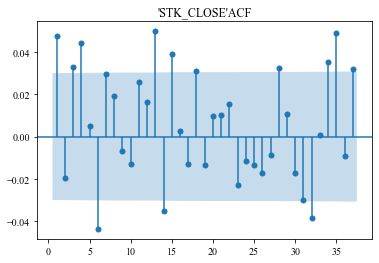

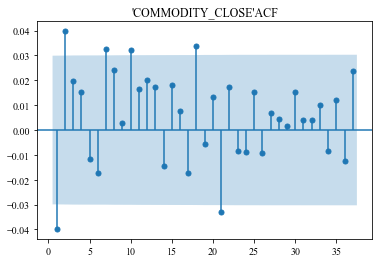

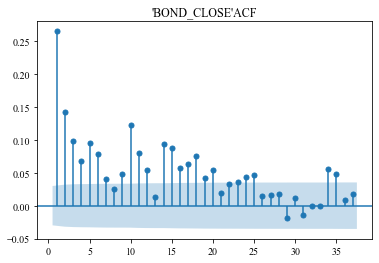

In [10]:
for fund in scaled_lr.columns: # hard to describe each index with a single time-series model
    plot_acf(scaled_lr.loc[:,fund],zero = False,title = "'{}'ACF".format(fund))
    plt.savefig(f"./Output/{fund} ACF.png",dpi = 300)

#### 3.收益率建模并获取残差

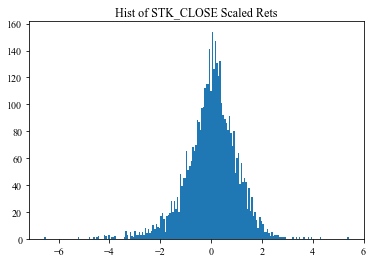

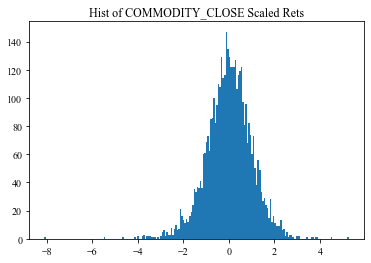

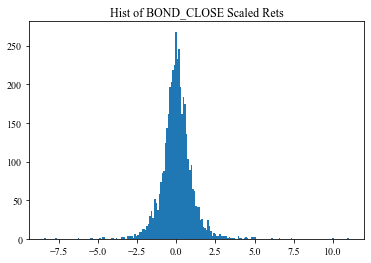

In [11]:
resid_list = dict()
conditional_vol = list()
models = dict()
for index in scaled_lr.columns:
    # AR(1)/GJR-GARCH(1,1) is not an appropriate model for bond index
    garch_model = arch_model(scaled_lr.loc[:,index],mean = "AR",lags = 1,vol = "GARCH", p = 1, o = 1, q = 1,dist = "normal",rescale = False,)
    garch_fit = garch_model.fit(disp = "off")
    model_resid = garch_fit.std_resid
    models[index] = garch_fit
    resid_list[index] = model_resid.dropna()
    conditional_vol.append(garch_fit.conditional_volatility.values[-1])
    plt.hist(model_resid.dropna().values,bins = 200,)
#     plt.title("'{}' Residuals ACF".format(index))
#     plot_acf(model_resid.dropna().values,zero = False)
    plt.title(f"Hist of {index} Scaled Rets")
    plt.savefig(f"./Output/{index} Hist.png",dpi = 300)
    plt.show()

#### 4.获取标准化残差序列的上中下尾

In [12]:
#定义正函数
def upper_generalized_pareto(x,zeta,beta):
    return 1-(1/(1+(zeta*x)/beta))**(1/zeta)

def lower_generalized_pareto(x,zeta,beta):
    return (1/(1+(zeta*(-x))/beta))**(1/zeta)

def middle_normal(x,miu,theta):
    return st.norm.cdf((x-miu)/theta)

def upper_generalized_exp(x,beta):
    return 1-np.exp(-x/beta)

def lower_generalized_exp(x,beta):
    return np.exp(x/beta)

In [13]:
#定义反函数
def reversedUpperGeneralizedPareto(y,zeta,beta):
    return beta*((1-y)**(-zeta)-1)/zeta

def reversedLowerGeneralizedPareto(y,zeta,beta):
    return beta*(1-y**(-zeta))/zeta

def reversedUpperGeneralizedExp(y,beta):
    return -beta*np.log(1-y)

def reversedLowerGeneralizedExp(y,beta):
    return beta*np.log(y)

def reversedMiddleNormal(y,miu,theta):
    return st.norm.ppf(y,loc = miu,scale = theta)

#### 5.根据t-copula生成标准化残差

In [14]:
from copulae import StudentCopula
from scipy.linalg import cholesky
from scipy.stats import t
from pynverse import inversefunc
from functools import partial

In [15]:
def inverseFunc(f,upper_params,middle_params,lower_params):
    if f<0:
        return 0
    elif f>=0 and f<=0.1:
        if len(lower_params) == 2:
            lower_inv = partial(reversedLowerGeneralizedPareto, zeta = lower_params[0], beta = lower_params[1])
        else:
            lower_inv = partial(reversedLowerGeneralizedExp, beta = lower_params[0])
        inv_ = lower_inv(f)
    elif f>0.1 and f<=0.9:
        middle_inv = partial(reversedMiddleNormal, miu = middle_params[0], theta = middle_params[1])
        inv_ = middle_inv(f)
    elif f>=0.9 and f<=1:
        if len(upper_params) == 2:
            upper_inv = partial(reversedUpperGeneralizedPareto, zeta = upper_params[0], beta = upper_params[1])
        else:
            upper_inv = partial(reversedUpperGeneralizedExp, beta = upper_params[0])
        inv_ = upper_inv(f)
    else:
        return 0
    return float(inv_)

In [16]:
def modifiedMeanModel(mu,beta,rt,resid):
    return mu+beta*rt+resid

##### 6.拟合CVaR时间序列

In [17]:
# Historical 21-Day Forward-Looking 95% CVaR(Log)
month_begin_end = pd.read_excel("./Data/月初月末表.xlsx")
week_begin_end = pd.read_excel("./Data/周初周末表.xlsx")

In [18]:
month_end = month_begin_end[month_begin_end.MONTH_END_ALL>="2006-12-31"].MONTH_END_ALL.tolist()
week_end = week_begin_end[week_begin_end.WEEK_START_ALL>="2006-12-31"].WEEK_START_ALL.tolist()

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
CVaR_df = pd.DataFrame(columns = ["95CVaR","90CVaR"])
simulation_num = 5000
base_weight = [1/asset_num]*asset_num
scenario_Rs = pd.DataFrame()
expected_Rs = pd.DataFrame()

for week in week_end:

    resid_list = dict() # residuals of each models
    conditional_vol = list()
    models = dict() # stimulation of each models
    scaled_lr_ = scaled_lr.loc[:week,:] # 1000 scaled log returns until the end of this week, no future data
    
#     print("model fit")
    for fund in scaled_lr_.columns:
        garch_model = arch_model(scaled_lr_.loc[:,fund],mean = "AR",lags = 1,vol = "GARCH", p = 1, o = 1, q = 1,dist = "normal",rescale = False,)
        garch_fit = garch_model.fit(disp = "off") 
        model_resid = garch_fit.std_resid 
        models[fund] = garch_fit # store model stimulation
        resid_list[fund] = model_resid.dropna() # store model residuals
        conditional_vol.append(garch_fit.conditional_volatility.values[-1]) 
    models_params = dict()
    
    # fit the tails, top 10% and tail 10%
    for asset_code,asset_resid in resid_list.items():
        upper_x = np.sort(asset_resid)[int(0.9*len(asset_resid)):]
        lower_x = np.sort(asset_resid)[:int(0.1*len(asset_resid))]
        middle_x = np.sort(asset_resid)[int(0.1*len(asset_resid)):int(0.9*len(asset_resid))]
        upper_f = np.linspace(0.9,1,len(upper_x))
        lower_f = np.linspace(0,0.1,len(lower_x))
        middle_f = np.linspace(0.1,0.9,len(middle_x))
        try:
            upper_params,upper_pcov = curve_fit(upper_generalized_pareto,upper_x,upper_f,bounds=([-0.5,0],[np.inf,np.inf]))
        except ValueError:
            upper_params,upper_pcov = curve_fit(upper_generalized_exp,upper_x,upper_f,bounds=([0],[np.inf]))
        try:
            lower_params,lower_pcov = curve_fit(lower_generalized_pareto,lower_x,lower_f,bounds=([-0.5,0],[np.inf,np.inf]))
        except ValueError:
            lower_params,lower_pcov = curve_fit(lower_generalized_exp,lower_x,lower_f,bounds=([0],[np.inf]))
        middle_params,middle_pcov = curve_fit(middle_normal,middle_x,middle_f)
        models_params[asset_code] = (upper_params,lower_params,middle_params)
        
#     print("path simulation")    
    residuals = pd.concat(resid_list.values(),axis = 1)
    residuals.columns = resid_list.keys()
    _, ndim = residuals.shape

    degrees_of_freedom = 6  # some random number, unnecessary to specify df but done for demonstration purposes
    t_copula = StudentCopula(dim = ndim, df = degrees_of_freedom)
    t_copula.fit(residuals,verbose = 0)
    corr_matrix = t_copula.sigma
    df = t_copula.params.df
    cholesky_lower = cholesky(corr_matrix,lower = True,)
    
    inverse_function_list = list()
    for key,value in models_params.items():
        temp_params = value
        temp_f = partial(inverseFunc,upper_params = temp_params[0],middle_params = temp_params[2],lower_params = temp_params[1])
        inverse_function_list.append(temp_f)
        
    fundMeanModel_list = list()
    for value in models.values():
        temp_f = partial(modifiedMeanModel,mu = value.params[0],beta = value.params[1])
        fundMeanModel_list.append(temp_f)
    
    scenario_R = np.empty((simulation_num,asset_num))
    for i in range(simulation_num):
        latest_return = scaled_lr_.values[-1].reshape(1,-1)

        Y = np.random.normal(0,1,size = (asset_num,days_num))
        chi = np.random.chisquare(df = df,size = days_num)
        W = np.dot(cholesky_lower,Y)
        X = W*df**0.5/chi**0.5
        U = t.cdf(X,df)

        Z = np.array([list(map(inverse_function_list[j],U[j])) for j in range(asset_num)]) 
        resid_ = np.array(conditional_vol).reshape(asset_num,1)*Z

        for x in range(days_num):
            simuate_R = np.array([fundMeanModel_list[z](rt = latest_return[-1][z],resid = resid_[:,x][z]) for z in range(asset_num)])
            latest_return = np.row_stack((latest_return,np.array(simuate_R)))

        scenario_R[i] = np.cumsum(latest_return[1:],axis = 0)[-1]
        
    expected_R = np.mean(scenario_R,axis = 0)
    scenario_Rs = scenario_Rs.append(pd.DataFrame(scenario_R))
    expected_Rs = expected_Rs.append(np.transpose(pd.DataFrame(expected_R)))
    
    portfolio_R = np.dot(scenario_R,base_weight)
    sorted_portfolio_R = np.sort(portfolio_R)
    CVaR_5pct = -np.mean(sorted_portfolio_R[:int(simulation_num*0.05)])#选择第5%的作为CVaR
    CVaR_10pct = -np.mean(sorted_portfolio_R[:int(simulation_num*0.1)])#选择第10%的作为CVaR
    
    CVaR_df.loc[week,["95CVaR","90CVaR"]] = CVaR_5pct,CVaR_10pct
    print(f"95% CVaR:{CVaR_5pct}, 90% CVaR:{CVaR_10pct}, End of Week:{week}")

95% CVaR:47.21224468135975, 90% CVaR:39.025757245855445, End of Week:2006-12-31 00:00:00
95% CVaR:49.760415713484676, 90% CVaR:41.09080823816519, End of Week:2007-01-07 00:00:00
95% CVaR:55.43910984264535, 90% CVaR:46.12835137402255, End of Week:2007-01-14 00:00:00
95% CVaR:67.312415063203, 90% CVaR:55.89051818775671, End of Week:2007-01-21 00:00:00
95% CVaR:70.46750889448775, 90% CVaR:58.408857432527874, End of Week:2007-01-28 00:00:00
95% CVaR:72.98435596568346, 90% CVaR:61.29358170972594, End of Week:2007-02-04 00:00:00
95% CVaR:67.25934255933309, 90% CVaR:55.83489290917532, End of Week:2007-02-11 00:00:00
95% CVaR:69.02651823522348, 90% CVaR:57.21632089009076, End of Week:2007-02-18 00:00:00
95% CVaR:69.30805120039274, 90% CVaR:57.50938946806799, End of Week:2007-02-25 00:00:00
95% CVaR:84.61791835096288, 90% CVaR:71.32931835330587, End of Week:2007-03-04 00:00:00
95% CVaR:74.38751340311897, 90% CVaR:62.07132927957898, End of Week:2007-03-11 00:00:00
95% CVaR:65.63005111393656, 90%

95% CVaR:130.2531478541886, 90% CVaR:108.35151697911347, End of Week:2008-10-12 00:00:00
95% CVaR:137.93319150058812, 90% CVaR:115.14850766909163, End of Week:2008-10-19 00:00:00
95% CVaR:125.71810210791882, 90% CVaR:106.32716205864708, End of Week:2008-10-26 00:00:00
95% CVaR:132.29480186042986, 90% CVaR:111.97192612621451, End of Week:2008-11-02 00:00:00
95% CVaR:125.28719020839962, 90% CVaR:104.44342959128943, End of Week:2008-11-09 00:00:00
95% CVaR:126.1755825097651, 90% CVaR:106.64978086895225, End of Week:2008-11-16 00:00:00
95% CVaR:142.0316375551815, 90% CVaR:118.81049920429183, End of Week:2008-11-23 00:00:00
95% CVaR:127.37843016210944, 90% CVaR:105.88027967352933, End of Week:2008-11-30 00:00:00
95% CVaR:119.81354347626156, 90% CVaR:99.46029339867516, End of Week:2008-12-07 00:00:00
95% CVaR:121.37773548731647, 90% CVaR:101.96656939035017, End of Week:2008-12-14 00:00:00
95% CVaR:110.63060188460216, 90% CVaR:92.82545244968168, End of Week:2008-12-21 00:00:00
95% CVaR:109.16

95% CVaR:59.30672535404261, 90% CVaR:48.76612103361287, End of Week:2010-07-25 00:00:00
95% CVaR:58.10196706312, 90% CVaR:48.382221378802754, End of Week:2010-08-01 00:00:00
95% CVaR:56.289714081717044, 90% CVaR:45.714990039506894, End of Week:2010-08-08 00:00:00
95% CVaR:58.28120303718338, 90% CVaR:48.2366097605541, End of Week:2010-08-15 00:00:00
95% CVaR:56.53833934416315, 90% CVaR:45.58226554403421, End of Week:2010-08-22 00:00:00
95% CVaR:58.56573297613498, 90% CVaR:48.06635334082934, End of Week:2010-08-29 00:00:00
95% CVaR:55.47183173335053, 90% CVaR:45.45562748053727, End of Week:2010-09-05 00:00:00
95% CVaR:54.7307054884571, 90% CVaR:44.89598206071146, End of Week:2010-09-12 00:00:00
95% CVaR:53.024848225035576, 90% CVaR:43.37734078970979, End of Week:2010-09-19 00:00:00
95% CVaR:54.70245653374647, 90% CVaR:44.3606166392833, End of Week:2010-09-26 00:00:00
95% CVaR:51.380890606585936, 90% CVaR:42.020043719810985, End of Week:2010-10-03 00:00:00
95% CVaR:49.87930784483404, 90% 

95% CVaR:48.75905156242235, 90% CVaR:40.04257067951678, End of Week:2012-05-06 00:00:00
95% CVaR:46.47050509281068, 90% CVaR:37.86351575980334, End of Week:2012-05-13 00:00:00
95% CVaR:53.018799695492575, 90% CVaR:43.416891652584894, End of Week:2012-05-20 00:00:00
95% CVaR:49.44960757476716, 90% CVaR:41.251806384296756, End of Week:2012-05-27 00:00:00
95% CVaR:47.893550007316456, 90% CVaR:39.67153284279095, End of Week:2012-06-03 00:00:00
95% CVaR:54.69472048200633, 90% CVaR:44.804322800276246, End of Week:2012-06-10 00:00:00
95% CVaR:54.28183730573741, 90% CVaR:44.4198656269937, End of Week:2012-06-17 00:00:00
95% CVaR:49.464445175452354, 90% CVaR:40.75610258869792, End of Week:2012-06-24 00:00:00
95% CVaR:48.02220094187617, 90% CVaR:40.09972500140885, End of Week:2012-07-01 00:00:00
95% CVaR:46.69248279256703, 90% CVaR:38.17436716986346, End of Week:2012-07-08 00:00:00
95% CVaR:47.57437894487596, 90% CVaR:38.978241794785234, End of Week:2012-07-15 00:00:00
95% CVaR:47.82031206746124

95% CVaR:48.161599104743715, 90% CVaR:40.567710464433375, End of Week:2014-02-16 00:00:00
95% CVaR:50.93059272967291, 90% CVaR:42.7999402881064, End of Week:2014-02-23 00:00:00
95% CVaR:55.18666858250376, 90% CVaR:46.16931974434843, End of Week:2014-03-02 00:00:00
95% CVaR:51.765641037252266, 90% CVaR:43.260152694557966, End of Week:2014-03-09 00:00:00
95% CVaR:59.29920874756675, 90% CVaR:49.34044090983044, End of Week:2014-03-16 00:00:00
95% CVaR:58.724464039569824, 90% CVaR:48.635041589035474, End of Week:2014-03-23 00:00:00
95% CVaR:56.36305460671795, 90% CVaR:46.83290146578875, End of Week:2014-03-30 00:00:00
95% CVaR:51.6552087007917, 90% CVaR:43.194339193179765, End of Week:2014-04-06 00:00:00
95% CVaR:51.60148669695305, 90% CVaR:42.74409559432037, End of Week:2014-04-13 00:00:00
95% CVaR:48.372339575778305, 90% CVaR:39.98590303802464, End of Week:2014-04-20 00:00:00
95% CVaR:48.83913597731874, 90% CVaR:40.450018457043214, End of Week:2014-04-27 00:00:00
95% CVaR:51.2308518857945

95% CVaR:79.36060454778206, 90% CVaR:66.64673417199857, End of Week:2015-11-29 00:00:00
95% CVaR:89.90961806010081, 90% CVaR:75.13699916470655, End of Week:2015-12-06 00:00:00
95% CVaR:84.26627365848998, 90% CVaR:70.62599130609684, End of Week:2015-12-13 00:00:00
95% CVaR:76.56233100159267, 90% CVaR:63.377214767525075, End of Week:2015-12-20 00:00:00
95% CVaR:73.22679169929694, 90% CVaR:60.144996426897386, End of Week:2015-12-27 00:00:00
95% CVaR:68.97599224506111, 90% CVaR:56.82080033578605, End of Week:2016-01-03 00:00:00
95% CVaR:122.44293033601518, 90% CVaR:102.34169139678959, End of Week:2016-01-10 00:00:00
95% CVaR:125.3174631251806, 90% CVaR:104.4801979377701, End of Week:2016-01-17 00:00:00
95% CVaR:122.71499480407336, 90% CVaR:102.94776241837046, End of Week:2016-01-24 00:00:00
95% CVaR:129.32991481345192, 90% CVaR:108.56423738332842, End of Week:2016-01-31 00:00:00
95% CVaR:121.67999770740398, 90% CVaR:101.22220336033678, End of Week:2016-02-07 00:00:00
95% CVaR:118.483367561

95% CVaR:41.78935438607407, 90% CVaR:34.114435673133066, End of Week:2017-09-10 00:00:00
95% CVaR:38.71709954057672, 90% CVaR:32.30336779864193, End of Week:2017-09-17 00:00:00
95% CVaR:41.43981223343319, 90% CVaR:34.405616378704394, End of Week:2017-09-24 00:00:00
95% CVaR:43.53038372738755, 90% CVaR:35.898896600662525, End of Week:2017-10-01 00:00:00
95% CVaR:45.12166090288053, 90% CVaR:37.213620368779345, End of Week:2017-10-08 00:00:00
95% CVaR:42.08715092077291, 90% CVaR:35.22068593064267, End of Week:2017-10-15 00:00:00
95% CVaR:46.02999344080474, 90% CVaR:38.07082475314998, End of Week:2017-10-22 00:00:00
95% CVaR:43.145350860873414, 90% CVaR:35.693682522477026, End of Week:2017-10-29 00:00:00
95% CVaR:43.15736753876765, 90% CVaR:35.501362914060635, End of Week:2017-11-05 00:00:00
95% CVaR:41.74119310911518, 90% CVaR:34.39637056927344, End of Week:2017-11-12 00:00:00
95% CVaR:41.63655357643085, 90% CVaR:34.35828632487572, End of Week:2017-11-19 00:00:00
95% CVaR:46.7700892026394

95% CVaR:66.86236457703649, 90% CVaR:55.44418767551534, End of Week:2019-06-23 00:00:00
95% CVaR:57.792169616242596, 90% CVaR:47.05051809184241, End of Week:2019-06-30 00:00:00
95% CVaR:56.81041057892929, 90% CVaR:47.04714487417618, End of Week:2019-07-07 00:00:00
95% CVaR:54.24163129358298, 90% CVaR:45.422289189410016, End of Week:2019-07-14 00:00:00
95% CVaR:50.45402762033524, 90% CVaR:41.70149051418181, End of Week:2019-07-21 00:00:00
95% CVaR:52.25312117323246, 90% CVaR:42.78465264795318, End of Week:2019-07-28 00:00:00
95% CVaR:47.72325861761257, 90% CVaR:39.15912172607711, End of Week:2019-08-04 00:00:00
95% CVaR:48.85731377735958, 90% CVaR:40.2749714704108, End of Week:2019-08-11 00:00:00
95% CVaR:46.4059818602787, 90% CVaR:38.09581875230857, End of Week:2019-08-18 00:00:00
95% CVaR:47.436735963162135, 90% CVaR:38.70572336089029, End of Week:2019-08-25 00:00:00
95% CVaR:42.66319743784963, 90% CVaR:34.97292798346609, End of Week:2019-09-01 00:00:00
95% CVaR:44.29083346102967, 90%

95% CVaR:60.41242528629392, 90% CVaR:50.25970820493925, End of Week:2021-04-04 00:00:00
95% CVaR:57.43051504542049, 90% CVaR:47.949014535738904, End of Week:2021-04-11 00:00:00
95% CVaR:56.50468895189895, 90% CVaR:46.13733512663044, End of Week:2021-04-18 00:00:00
95% CVaR:50.56299035995861, 90% CVaR:41.362753632261736, End of Week:2021-04-25 00:00:00
95% CVaR:50.33532674323589, 90% CVaR:41.037020190503306, End of Week:2021-05-02 00:00:00
95% CVaR:55.44248854725175, 90% CVaR:45.5347251208167, End of Week:2021-05-09 00:00:00
95% CVaR:60.664347458025425, 90% CVaR:50.433007641405084, End of Week:2021-05-16 00:00:00
95% CVaR:64.06059406594606, 90% CVaR:52.592006937582596, End of Week:2021-05-23 00:00:00
95% CVaR:60.09798911713802, 90% CVaR:49.838126062990455, End of Week:2021-05-30 00:00:00
95% CVaR:56.88553880388128, 90% CVaR:47.210150704468965, End of Week:2021-06-06 00:00:00
95% CVaR:52.32822368424898, 90% CVaR:43.9962321069553, End of Week:2021-06-13 00:00:00
95% CVaR:55.21449190120733

In [21]:
CVaR_df.to_excel('./Output/CVaR_df.xlsx')

##### 7.CVaR时间序列作图

In [9]:
CVaR_df = pd.read_excel("./Output/CVaR_df.xlsx",index_col = 0)
indice_series = pd.read_excel("./Data/指数行情序列.xlsx",index_col = 0)

In [20]:
CVaR_ = CVaR_df.loc[:,"95CVaR"]

In [6]:
def getDrawdowns(array):
    drawdowns = []
    max_so_far = array[0]
    for i in range(len(array)):
        if array[i] > max_so_far:
            drawdown = 0
            drawdowns.append(drawdown)
            max_so_far = array[i]
        else:
            drawdown = max_so_far - array[i]
            drawdowns.append(drawdown)
    return drawdowns

In [31]:
drawdowns = getDrawdowns(indice_series.loc[CVaR_df.index[0]:CVaR_df.index[-1]].CLOSE)

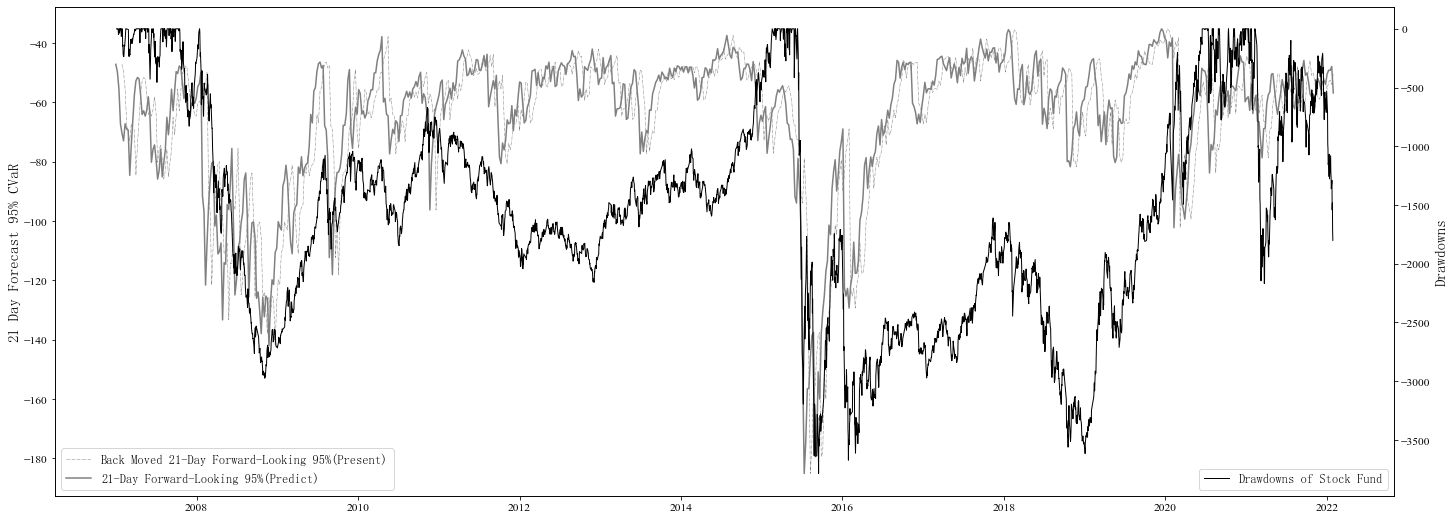

In [44]:
matplotlib.rcParams['font.sans-serif']=['simsun'] 
fig = plt.figure(figsize = (24,9))
ax1 = fig.add_subplot(111)
ax1.plot(CVaR_.index[4:],-CVaR_[:-4], "-.",color = "grey",linewidth = 0.5)#非预测对比序列
ax1.plot(CVaR_.index,-CVaR_, "-",color = "grey",)#预测对比序列
plt.legend(["Back Moved 21-Day Forward-Looking 95%(Present)","21-Day Forward-Looking 95%(Predict)"], loc='lower left',fontsize = 12.5,)
plt.xticks(fontproperties='Times New Roman', size=11.5)
plt.yticks(fontproperties='Times New Roman', size=11.5)
ax1.set_ylabel("21 Day Forecast 95% CVaR",fontsize = 15,weight='bold')
ax2 = ax1.twinx()#真实指数序列
ax2.plot(indice_series.loc[CVaR_df.index[0]:CVaR_df.index[-1]].CLOSE.index,-np.array(drawdowns),color = "black",linewidth = 1)
plt.legend(["Drawdowns of Stock Fund"], loc='lower right',fontsize = 12.5)
ax2.set_ylabel("Drawdowns",fontsize = 15,weight='bold',)
plt.yticks(fontproperties='Times New Roman', size=11.5)
plt.savefig("./Output//周度_CVaR序列.png",dpi = 500)
plt.show()